In [1]:
# Cell 1: Environment, imports, seeds, config
import os, random, time, json
from copy import deepcopy
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader, WeightedRandomSampler

from datasets import Dataset
from transformers import (AutoTokenizer, AutoModelForSequenceClassification,
                          get_linear_schedule_with_warmup)

from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_recall_fscore_support,
                             confusion_matrix, roc_auc_score, roc_curve, classification_report)

# reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Config (adjust as needed)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_NAME = "roberta-base"
MAX_LENGTH = 256        # sequence length
BATCH_SIZE = 8
N_EPOCHS = 3
LR = 2e-5
OUTPUT_DIR = "centralized_model"
os.makedirs(OUTPUT_DIR, exist_ok=True)

DATA_CSV = "combined_healthcare_prompts_mini.csv"  # ensure this is in runtime
print("DEVICE:", DEVICE)
print("MODEL:", MODEL_NAME, "MAX_LEN:", MAX_LENGTH, "BATCH:", BATCH_SIZE)


DEVICE: cuda
MODEL: roberta-base MAX_LEN: 256 BATCH: 8


In [3]:
# Cell 2 (FIXED for your dataset): Load CSV + create `text` and `label`

df = pd.read_csv(DATA_CSV)
print("CSV columns:", df.columns.tolist())

# Fix capitalization + spacing by normalizing column names
df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]
print("Normalized columns:", df.columns.tolist())

# Now expected columns are: system_prompt, user_prompt, label

# Create text column by concatenating system + user prompts
if "system_prompt" in df.columns and "user_prompt" in df.columns:
    df["text"] = (
        df["system_prompt"].fillna("") + " " + df["user_prompt"].fillna("")
    ).str.strip()
    print("Created `text` column from system_prompt + user_prompt")
else:
    raise ValueError("Expected columns 'System Prompt' and 'User Prompt' in CSV.")

# Fix label column
if "label" in df.columns:
    df["label"] = df["label"].astype(int)
else:
    raise ValueError("Expected column 'Label' in CSV.")

print("Dataset size:", len(df))
print(df["label"].value_counts(), "\nfractions:\n", df["label"].value_counts(normalize=True))


CSV columns: ['System Prompt', 'User Prompt', 'Label']
Normalized columns: ['system_prompt', 'user_prompt', 'label']
Created `text` column from system_prompt + user_prompt
Dataset size: 7243
label
1    4294
0    2949
Name: count, dtype: int64 
fractions:
 label
1    0.592848
0    0.407152
Name: proportion, dtype: float64


In [4]:
# Cell 3: Stratified train/val/test split (80/10/10)
train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df["label"], random_state=SEED)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df["label"], random_state=SEED)

print("Sizes -> train, val, test:", len(train_df), len(val_df), len(test_df))
print("Label dist train/val/test:",
      train_df["label"].value_counts().to_dict(),
      val_df["label"].value_counts().to_dict(),
      test_df["label"].value_counts().to_dict())

# Convert to HF Datasets (tokenize after)
train_ds = Dataset.from_pandas(train_df.reset_index(drop=True))
val_ds   = Dataset.from_pandas(val_df.reset_index(drop=True))
test_ds  = Dataset.from_pandas(test_df.reset_index(drop=True))


Sizes -> train, val, test: 5794 724 725
Label dist train/val/test: {1: 3435, 0: 2359} {1: 429, 0: 295} {1: 430, 0: 295}


In [5]:
# Cell 4: Tokenizer + batched tokenization
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)

def tokenize_fn(batch):
    return tokenizer(batch["text"], truncation=True, padding="max_length", max_length=MAX_LENGTH)

train_ds = train_ds.map(tokenize_fn, batched=True, remove_columns=[c for c in train_ds.column_names if c not in ("text","label")])
val_ds   = val_ds.map(tokenize_fn, batched=True, remove_columns=[c for c in val_ds.column_names if c not in ("text","label")])
test_ds  = test_ds.map(tokenize_fn, batched=True, remove_columns=[c for c in test_ds.column_names if c not in ("text","label")])

cols = ["input_ids", "attention_mask", "label"]
train_ds.set_format(type="torch", columns=cols)
val_ds.set_format(type="torch", columns=cols)
test_ds.set_format(type="torch", columns=cols)

print("Tokenization complete. Example features:", train_ds.features)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/5794 [00:00<?, ? examples/s]

Map:   0%|          | 0/724 [00:00<?, ? examples/s]

Map:   0%|          | 0/725 [00:00<?, ? examples/s]

Tokenization complete. Example features: {'label': Value('int64'), 'text': Value('string'), 'input_ids': List(Value('int32')), 'attention_mask': List(Value('int8'))}


In [6]:
# Cell 5: DataLoaders + optional WeightedRandomSampler
from torch.utils.data import DataLoader

def collate_fn(batch):
    input_ids = torch.stack([item["input_ids"] for item in batch])
    attention_mask = torch.stack([item["attention_mask"] for item in batch])
    labels = torch.tensor([int(item["label"]) for item in batch], dtype=torch.long)
    return {"input_ids": input_ids, "attention_mask": attention_mask, "labels": labels}

# default loaders
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

# compute class counts for optional balancing
train_labels = [int(x) for x in train_ds["label"]]
counts = Counter(train_labels)
print("Train label counts:", counts)
# optional weighted sampler (uncomment to use)
# from sklearn.utils import class_weight
# class_weights = compute_class_weight("balanced", classes=np.array([0,1]), y=np.array(train_labels))
# etc.


Train label counts: Counter({1: 3435, 0: 2359})


In [7]:
# Cell 6: Evaluation helper (compute acc, precision, recall, f1, confusion)
def evaluate_model(model, dataloader):
    model.eval()
    preds, golds, probs = [], [], []
    losses = []
    with torch.no_grad():
        for b in dataloader:
            input_ids = b["input_ids"].to(DEVICE)
            attn = b["attention_mask"].to(DEVICE)
            labels = b["labels"].to(DEVICE)
            outputs = model(input_ids=input_ids, attention_mask=attn)
            logits = outputs.logits
            p = torch.argmax(logits, dim=-1).detach().cpu().numpy().tolist()
            prob = torch.softmax(logits, dim=-1).detach().cpu().numpy().tolist()
            preds.extend(p)
            golds.extend(labels.detach().cpu().numpy().tolist())
            probs.extend(prob)
    acc = accuracy_score(golds, preds)
    prec, rec, f1, _ = precision_recall_fscore_support(golds, preds, average="binary", zero_division=0)
    try:
        auc = roc_auc_score(golds, [p[1] for p in probs])
    except:
        auc = None
    return {"accuracy": acc, "precision": prec, "recall": rec, "f1": f1, "auc": auc, "preds": preds, "golds": golds}


In [8]:
# Cell 7: Load model & prepare optimizer, scheduler, weighted loss
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2).to(DEVICE)

optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
total_steps = len(train_loader) * N_EPOCHS
warmup_steps = max(1, int(0.06 * total_steps))
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)

# compute class weights and set criterion
train_labels = np.array([int(x) for x in train_ds["label"]])
class_sample_counts = np.bincount(train_labels)
inv_freq = len(train_labels) / (class_sample_counts + 1e-9)
class_weights = torch.tensor(inv_freq, dtype=torch.float).to(DEVICE)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
print("Class counts:", class_sample_counts, "class_weights:", class_weights.cpu().numpy())


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Class counts: [2359 3435] class_weights: [2.4561255 1.686754 ]


In [9]:
# Cell 8: Centralized training loop (weighted loss) + validation / checkpointing
best_val_f1 = -1.0
history = {"train_loss": [], "val_f1": [], "val_loss": []}

for epoch in range(1, N_EPOCHS + 1):
    model.train()
    running_loss = 0.0
    steps = 0
    t0 = time.time()
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(DEVICE)
        attn = batch["attention_mask"].to(DEVICE)
        labels = batch["labels"].to(DEVICE)
        outputs = model(input_ids=input_ids, attention_mask=attn)
        logits = outputs.logits
        loss = criterion(logits, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        running_loss += loss.item()
        steps += 1
    avg_train_loss = running_loss / max(1, steps)
    val_metrics = evaluate_model(model, val_loader)
    history["train_loss"].append(avg_train_loss)
    history["val_f1"].append(val_metrics["f1"])
    print(f"Epoch {epoch} done | train_loss={avg_train_loss:.4f} val_f1={val_metrics['f1']:.4f} val_acc={val_metrics['accuracy']:.4f} time={time.time()-t0:.1f}s")
    if val_metrics["f1"] > best_val_f1:
        best_val_f1 = val_metrics["f1"]
        print("New best val F1:", best_val_f1, " -> saving model")
        model.save_pretrained(OUTPUT_DIR)
        tokenizer.save_pretrained(OUTPUT_DIR)

print("Centralized training finished. Best val F1:", best_val_f1)


Epoch 1 done | train_loss=0.2724 val_f1=0.9591 val_acc=0.9503 time=279.4s
New best val F1: 0.9590909090909091  -> saving model
Epoch 2 done | train_loss=0.1232 val_f1=0.9601 val_acc=0.9517 time=278.4s
New best val F1: 0.9600912200684151  -> saving model
Epoch 3 done | train_loss=0.0723 val_f1=0.9571 val_acc=0.9503 time=278.4s
Centralized training finished. Best val F1: 0.9600912200684151


CENTRALIZED TEST METRICS: {'accuracy': 0.96, 'precision': 0.950561797752809, 'recall': 0.9837209302325581, 'f1': 0.9668571428571429, 'auc': np.float64(0.9957903035080804)}
Confusion matrix:
 [[273  22]
 [  7 423]]


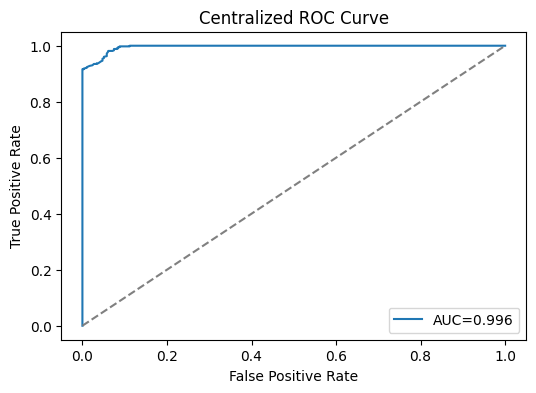

In [10]:
# Cell 9 (FIXED): Evaluate + Confusion Matrix + ROC Curve

best_model = AutoModelForSequenceClassification.from_pretrained(OUTPUT_DIR).to(DEVICE)
best_model.eval()

res = evaluate_model(best_model, test_loader)
print("CENTRALIZED TEST METRICS:", {k: v for k,v in res.items() if k in ('accuracy','precision','recall','f1','auc')})

# -----------------------------
# CONFUSION MATRIX
# -----------------------------
cm = confusion_matrix(res["golds"], res["preds"])
print("Confusion matrix:\n", cm)

# -----------------------------
# ROC CURVE (binary classification only)
# -----------------------------
# We MUST recompute probabilities manually (evaluate_model only returned preds, not probs)
probs = []
labels = []

with torch.no_grad():
    for b in test_loader:
        outputs = best_model(
            input_ids=b["input_ids"].to(DEVICE),
            attention_mask=b["attention_mask"].to(DEVICE)
        )
        logits = outputs.logits.cpu().numpy()

        # For binary classification, probs = sigmoid(logit_of_class_1)
        if logits.shape[1] == 1:
            # Rare case: single-logit binary classifier
            p = 1 / (1 + np.exp(-logits[:, 0]))
        else:
            # Standard 2-class softmax
            p = torch.softmax(torch.tensor(logits), dim=1)[:, 1].numpy()

        probs.extend(p.tolist())
        labels.extend(b["labels"].numpy().tolist())

# If binary classification → plot ROC
if len(np.unique(labels)) == 2:
    fpr, tpr, _ = roc_curve(labels, probs)
    auc_val = roc_auc_score(labels, probs)

    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f"AUC={auc_val:.3f}")
    plt.plot([0, 1], [0, 1], '--', color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Centralized ROC Curve")
    plt.legend()
    plt.show()
else:
    print("ROC curve skipped: ROC/AUC requires binary classification.")


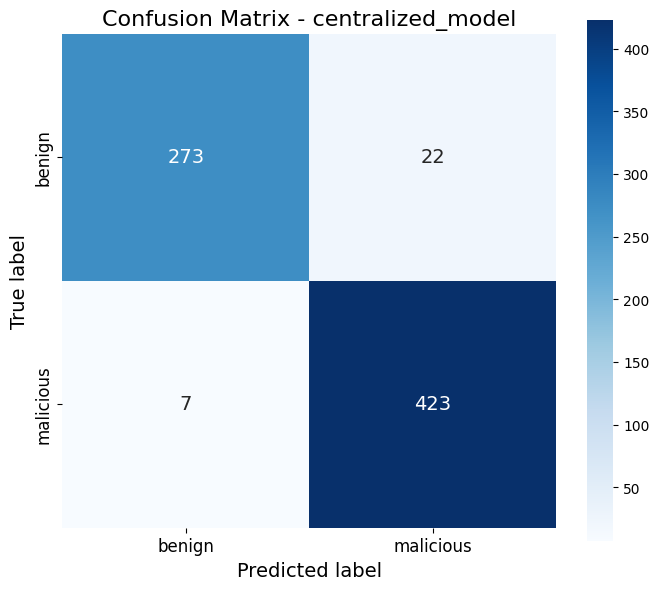

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Compute confusion matrix
cm = confusion_matrix(res["golds"], res["preds"])

# If your labels are 0/1, map them to class names:
# Change names here as needed
id2name = {0: "benign", 1: "malicious"}

# Create labeled DataFrame for heatmap
cm_df = pd.DataFrame(
    cm,
    index=[id2name[i] for i in range(cm.shape[0])],
    columns=[id2name[i] for i in range(cm.shape[1])]
)

# Plot heatmap
plt.figure(figsize=(7, 6))
sns.heatmap(
    cm_df,
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar=True,
    square=True,
    annot_kws={"size": 14}
)

plt.title("Confusion Matrix - centralized_model", fontsize=16)
plt.xlabel("Predicted label", fontsize=14)
plt.ylabel("True label", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


In [12]:
# Cell 10: Federated split helpers (IID and Dirichlet Non-IID)
def split_iid_indices(n_samples, num_clients):
    idxs = np.arange(n_samples)
    np.random.shuffle(idxs)
    return np.array_split(idxs, num_clients)

def split_dirichlet(labels, num_clients, alpha=0.3):
    # returns list of arrays of indices for each client (dirichlet partition)
    labels = np.array(labels)
    num_classes = len(np.unique(labels))
    idx_by_class = [np.where(labels == c)[0] for c in range(num_classes)]
    client_indices = [[] for _ in range(num_clients)]
    for c, idx_c in enumerate(idx_by_class):
        proportions = np.random.dirichlet(alpha=[alpha]*num_clients)
        # make proportions sum to number of samples in class
        proportions = (np.cumsum(proportions) * len(idx_c)).astype(int)
        prev = 0
        for i, cut in enumerate(proportions):
            sel = idx_c[prev:cut]
            client_indices[i].extend(sel.tolist())
            prev = cut
    client_indices = [np.array(sorted(ci)) for ci in client_indices]
    return client_indices


In [13]:
# === Cell A: Diagnostic check for dataset / loader / splits ===
import torch
from torch.utils.data import DataLoader

# quick sanity prints for core objects
print("Sanity check: core workspace objects present:")
for name in ["train_ds","val_ds","test_ds"]:
    print(name, "in globals()->", name in globals())
    if name in globals():
        ds = globals()[name]
        try:
            print("  type:", type(ds), "len:", len(ds), "columns:", getattr(ds, "column_names", None))
        except Exception as e:
            print("  ERROR inspecting", name, e)

# print your splits if available
print("\nIf you created iid_splits/noniid_splits earlier, inspect them now:")
for n in ["iid_splits","noniid_splits","client_splits","client_dsets","client_loaders"]:
    if n in globals():
        print(n, "-> type:", type(globals()[n]))
        try:
            x = globals()[n]
            if isinstance(x, (list, tuple)):
                print("  len:", len(x))
                for i, part in enumerate(x[:6]):
                    try:
                        print(f"   [{i}] type={type(part)} len={ (len(part) if hasattr(part,'__len__') else 'no-len') }")
                    except Exception as e:
                        print("   inspect error:", e)
        except Exception as e:
            print("  inspect error:", e)
    else:
        print(n, "not defined")

# Verify helper make_loader_from_indices behavior if it exists
print("\nTest building a loader for the first split (if splits exist):")
if "iid_splits" in globals() and len(iid_splits)>0:
    try:
        first = iid_splits[0]
        print("iid_splits[0] length:", len(first))
        # attempt to build loader similar to your code
        # Use whichever helper your notebook uses; fallback to HF .select(...) approach:
        subset = train_ds.select(list(map(int, list(first)[:min(20,len(first))])))
        print("subset type:", type(subset), "len:", len(subset))
        # try set_format
        subset.set_format(type="torch", columns=["input_ids","attention_mask","label"])
        loader = DataLoader(subset, batch_size=4, shuffle=True)
        print("loader built OK, dataset len:", len(loader.dataset))
    except Exception as e:
        print("Failed to build loader from iid_splits[0]:", e)
else:
    print("No iid_splits found to test")


Sanity check: core workspace objects present:
train_ds in globals()-> True
  type: <class 'datasets.arrow_dataset.Dataset'> len: 5794 columns: ['label', 'text', 'input_ids', 'attention_mask']
val_ds in globals()-> True
  type: <class 'datasets.arrow_dataset.Dataset'> len: 724 columns: ['label', 'text', 'input_ids', 'attention_mask']
test_ds in globals()-> True
  type: <class 'datasets.arrow_dataset.Dataset'> len: 725 columns: ['label', 'text', 'input_ids', 'attention_mask']

If you created iid_splits/noniid_splits earlier, inspect them now:
iid_splits not defined
noniid_splits not defined
client_splits not defined
client_dsets not defined
client_loaders not defined

Test building a loader for the first split (if splits exist):
No iid_splits found to test


In [22]:
def run_fed_with_loaders_safe(loaders, rounds=3, local_epochs=1, device=None, model_name=None, mode="iid"):
    """
    Simple FedAvg runner that expects `loaders` to be a list of DataLoaders (one per client).
    Returns dict with history and final model and per-round val metrics.
    """

    if device is None:
        device = DEVICE if 'DEVICE' in globals() else ("cuda" if torch.cuda.is_available() else "cpu")
    if model_name is None:
        model_name = globals().get("MODEL_NAME", globals().get("MODEL", "roberta-base"))

    print(f"Initializing global model from {model_name} -> device {device}")
    global_model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2).to(device)
    global_state = deepcopy(global_model.state_dict())

    history = {"rounds": [], "val_f1": [], "val_acc": [], "client_losses": []}

    # ------------------ FedAvg rounds ------------------
    for r in range(1, rounds+1):
        print(f"\n--- Fed Round {r}/{rounds} ---")
        client_states = []
        client_losses = []

        for i, loader in enumerate(loaders):
            try:
                n_samples = len(loader.dataset)
            except:
                n_samples = None

            print(f" Client {i+1}: training on approx {n_samples} samples (loader type {type(loader)})")

            # local copy of model
            local_model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
            local_model.load_state_dict(global_state)
            local_model.to(device)

            opt = torch.optim.AdamW(local_model.parameters(), lr=globals().get("LR", 2e-5))
            local_model.train()

            running_loss, steps = 0.0, 0

            for _ep in range(local_epochs):
                for b in loader:
                    opt.zero_grad()
                    x = b["input_ids"].to(device)
                    am = b["attention_mask"].to(device)
                    y = b.get("labels", b.get("label")).to(device)

                    out = local_model(input_ids=x, attention_mask=am, labels=y)
                    loss = out.loss
                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(local_model.parameters(), 1.0)
                    opt.step()

                    running_loss += loss.item()
                    steps += 1

            avg_loss = running_loss / steps if steps > 0 else 0.0
            print(f"  Client {i+1} done → loss={avg_loss:.4f}, steps={steps}")

            client_losses.append(avg_loss)
            client_states.append({k: v.cpu() for k, v in local_model.state_dict().items()})

        # ---------- FedAvg aggregation ----------
        new_state = {}
        for k in client_states[0].keys():
            stacked = torch.stack([sd[k].float() for sd in client_states], dim=0)
            new_state[k] = torch.mean(stacked, dim=0)

        global_state = new_state
        global_model.load_state_dict(global_state)

        # ---------- Validation ----------
        if "val_loader" in globals():
            vm = evaluate_model(global_model.to(device), val_loader)
            print(f" Round {r} validation → F1={vm['f1']:.4f}, Acc={vm['accuracy']:.4f}")

            history["val_f1"].append(vm["f1"])
            history["val_acc"].append(vm["accuracy"])
        else:
            print(" No val_loader found → skipping validation metrics.")
            history["val_f1"].append(None)
            history["val_acc"].append(None)

        history["client_losses"].append(client_losses)
        history["rounds"].append(r)

    # ---------- Final test eval ----------
    final_metrics = None
    if "test_loader" in globals():
        final_metrics = evaluate_model(global_model.to(device), test_loader)
        print("Final test metrics →", final_metrics)
    else:
        print("No test_loader found → skipping final test eval.")

    # =====================================================================
    # ★★★ ADDITION: SAVE HISTORY TO DISK (for plotting later) ★★★
    # =====================================================================
    import json, os

    OUTPUT_DIR = globals().get("OUTPUT_DIR", "centralized_model")
    os.makedirs(OUTPUT_DIR, exist_ok=True)

    history_path = os.path.join(OUTPUT_DIR, f"fed_history_{mode}.json")

    # convert numpy types to Python for JSON
    def _to_py(o):
        import numpy as np
        if isinstance(o, (np.floating, float)): return float(o)
        if isinstance(o, (np.integer, int)): return int(o)
        if isinstance(o, list): return [_to_py(x) for x in o]
        return o

    try:
        with open(history_path, "w") as f:
            json.dump(_to_py(history), f, indent=2)
        print(f"\nSaved federated history → {history_path}\n")
    except Exception as e:
        print("WARNING: Could not save history:", e)
    # =====================================================================

    return {"history": history, "final_metrics": final_metrics, "global_model_state": global_state}


In [24]:
ROUNDS = 4        # or 3, 5 — your choice
LOCAL_EPOCHS = 3    # number of epochs each client trains locally



In [25]:
res_iid = run_fed_with_loaders_safe(iid_loaders, rounds=ROUNDS, local_epochs=LOCAL_EPOCHS)
res_non = run_fed_with_loaders_safe(noniid_loaders, rounds=ROUNDS, local_epochs=LOCAL_EPOCHS)


Initializing global model from roberta-base -> device cuda


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Fed Round 1/4 ---
 Client 1: training on approx 1932 samples (loader type <class 'torch.utils.data.dataloader.DataLoader'>)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Client 1 done → loss=0.2229, steps=726
 Client 2: training on approx 1931 samples (loader type <class 'torch.utils.data.dataloader.DataLoader'>)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Client 2 done → loss=0.1861, steps=726
 Client 3: training on approx 1931 samples (loader type <class 'torch.utils.data.dataloader.DataLoader'>)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Client 3 done → loss=0.2226, steps=726
 Round 1 validation → F1=0.9612, Acc=0.9530

--- Fed Round 2/4 ---
 Client 1: training on approx 1932 samples (loader type <class 'torch.utils.data.dataloader.DataLoader'>)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Client 1 done → loss=0.1275, steps=726
 Client 2: training on approx 1931 samples (loader type <class 'torch.utils.data.dataloader.DataLoader'>)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Client 2 done → loss=0.1193, steps=726
 Client 3: training on approx 1931 samples (loader type <class 'torch.utils.data.dataloader.DataLoader'>)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Client 3 done → loss=0.1318, steps=726
 Round 2 validation → F1=0.9535, Acc=0.9448

--- Fed Round 3/4 ---
 Client 1: training on approx 1932 samples (loader type <class 'torch.utils.data.dataloader.DataLoader'>)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Client 1 done → loss=0.1165, steps=726
 Client 2: training on approx 1931 samples (loader type <class 'torch.utils.data.dataloader.DataLoader'>)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Client 2 done → loss=0.1051, steps=726
 Client 3: training on approx 1931 samples (loader type <class 'torch.utils.data.dataloader.DataLoader'>)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Client 3 done → loss=0.1121, steps=726
 Round 3 validation → F1=0.9585, Acc=0.9503

--- Fed Round 4/4 ---
 Client 1: training on approx 1932 samples (loader type <class 'torch.utils.data.dataloader.DataLoader'>)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Client 1 done → loss=0.1190, steps=726
 Client 2: training on approx 1931 samples (loader type <class 'torch.utils.data.dataloader.DataLoader'>)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Client 2 done → loss=0.0950, steps=726
 Client 3: training on approx 1931 samples (loader type <class 'torch.utils.data.dataloader.DataLoader'>)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Client 3 done → loss=0.1011, steps=726
 Round 4 validation → F1=0.9635, Acc=0.9558
Final test metrics → {'accuracy': 0.9572413793103448, 'precision': 0.9523809523809523, 'recall': 0.9767441860465116, 'f1': 0.9644087256027555, 'auc': np.float64(0.9960346866377612), 'preds': [1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Fed Round 1/4 ---
 Client 1: training on approx 2269 samples (loader type <class 'torch.utils.data.dataloader.DataLoader'>)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Client 1 done → loss=0.0580, steps=852
 Client 2: training on approx 461 samples (loader type <class 'torch.utils.data.dataloader.DataLoader'>)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Client 2 done → loss=0.0761, steps=174
 Client 3: training on approx 3064 samples (loader type <class 'torch.utils.data.dataloader.DataLoader'>)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Client 3 done → loss=0.0813, steps=1149
 Round 1 validation → F1=0.8363, Acc=0.7680

--- Fed Round 2/4 ---
 Client 1: training on approx 2269 samples (loader type <class 'torch.utils.data.dataloader.DataLoader'>)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Client 1 done → loss=0.0290, steps=852
 Client 2: training on approx 461 samples (loader type <class 'torch.utils.data.dataloader.DataLoader'>)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Client 2 done → loss=0.0454, steps=174
 Client 3: training on approx 3064 samples (loader type <class 'torch.utils.data.dataloader.DataLoader'>)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Client 3 done → loss=0.0451, steps=1149
 Round 2 validation → F1=0.9575, Acc=0.9489

--- Fed Round 3/4 ---
 Client 1: training on approx 2269 samples (loader type <class 'torch.utils.data.dataloader.DataLoader'>)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Client 1 done → loss=0.0165, steps=852
 Client 2: training on approx 461 samples (loader type <class 'torch.utils.data.dataloader.DataLoader'>)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Client 2 done → loss=0.0010, steps=174
 Client 3: training on approx 3064 samples (loader type <class 'torch.utils.data.dataloader.DataLoader'>)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Client 3 done → loss=0.0439, steps=1149
 Round 3 validation → F1=0.9636, Acc=0.9558

--- Fed Round 4/4 ---
 Client 1: training on approx 2269 samples (loader type <class 'torch.utils.data.dataloader.DataLoader'>)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Client 1 done → loss=0.0149, steps=852
 Client 2: training on approx 461 samples (loader type <class 'torch.utils.data.dataloader.DataLoader'>)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Client 2 done → loss=0.0074, steps=174
 Client 3: training on approx 3064 samples (loader type <class 'torch.utils.data.dataloader.DataLoader'>)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Client 3 done → loss=0.0317, steps=1149
 Round 4 validation → F1=0.9648, Acc=0.9572
Final test metrics → {'accuracy': 0.9544827586206897, 'precision': 0.9480812641083521, 'recall': 0.9767441860465116, 'f1': 0.9621993127147767, 'auc': np.float64(0.9940875049270792), 'preds': [1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0,

Device: cuda OUTDIR: centralized_model
Loaded history from variable res_iid
Loaded history from variable res_non
Recreating model from provided global_model_state in res var.


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Recreating model from provided global_model_state in res var.


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


test_loader found. Example batch keys: ['input_ids', 'attention_mask', 'labels']
IID: acc=0.9572 auc=0.9960110366574695
Non-IID: acc=0.9545 auc=0.9941663381947181


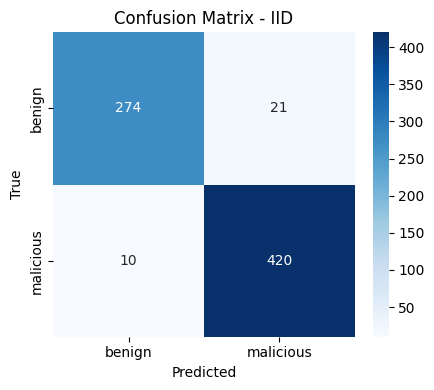

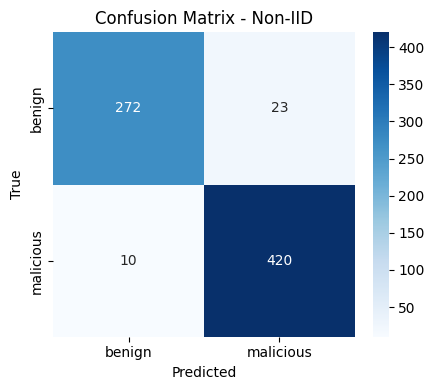

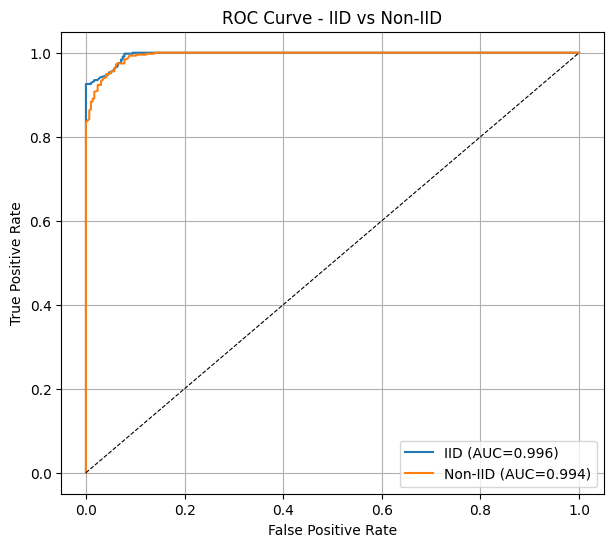

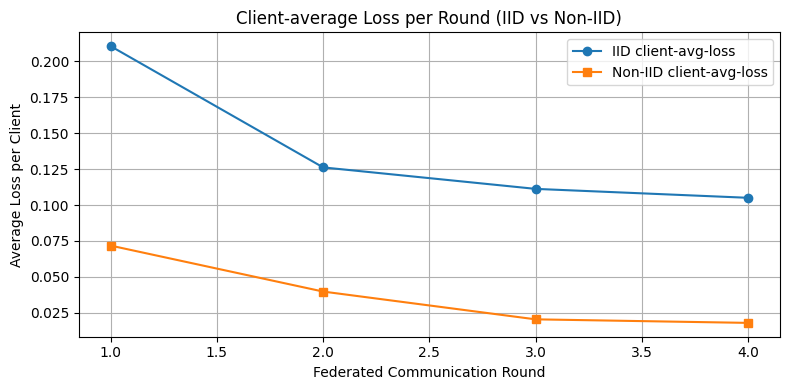

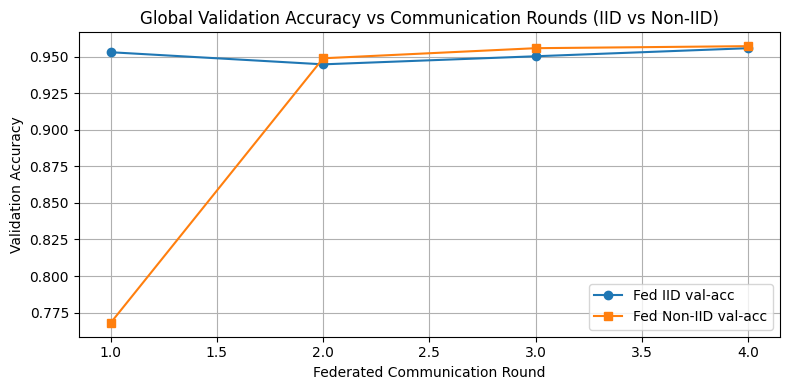

Done. If any plot is missing data, check the printed messages above to see which item is absent (history file, model paths, or test_loader labels).


In [26]:
# Single cell: plot Confusion matrices, ROC (IID vs Non-IID), Loss vs Rounds, Accuracy vs Rounds
import os, json, numpy as np, matplotlib.pyplot as plt, seaborn as sns, torch
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score
from transformers import AutoModelForSequenceClassification, AutoTokenizer

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
OUTDIR = globals().get("OUTPUT_DIR", "centralized_model")
MODEL_NAME = globals().get("MODEL_NAME", "roberta-base")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

print("Device:", DEVICE, "OUTDIR:", OUTDIR)

# --- helper: load history from res dict or file ---
def load_history(res_var, default_fname):
    if res_var in globals() and globals()[res_var] is not None:
        r = globals()[res_var]
        if isinstance(r, dict) and "history" in r:
            print(f"Loaded history from variable {res_var}")
            return r["history"], r
        # if res is directly the history dict
        if isinstance(r, dict) and set(("rounds","client_losses")).issubset(set(r.keys())):
            print(f"{res_var} appears to be a history dict")
            return r, None
    # fallback to file
    fp = os.path.join(OUTDIR, default_fname)
    if os.path.exists(fp):
        try:
            with open(fp, "r") as f:
                h = json.load(f)
            print("Loaded history from", fp)
            return h, None
        except Exception as e:
            print("Failed to load history file:", e)
    print("No history found for", res_var)
    return None, None

# --- helper: get final model for experiment (prefer last saved model path, else global_model_state in res) ---
def load_final_model_from_history(history_obj, res_obj, model_name=MODEL_NAME, num_labels=globals().get("NUM_LABELS", 2)):
    # history_obj may be dict with "model_paths" list
    if history_obj:
        mpaths = history_obj.get("model_paths") or history_obj.get("model_paths", None)
        if mpaths and isinstance(mpaths, list) and len(mpaths)>0:
            last = mpaths[-1]
            if os.path.isdir(last):
                print("Loading model from saved path:", last)
                m = AutoModelForSequenceClassification.from_pretrained(last, num_labels=num_labels).to(DEVICE)
                m.eval()
                return m
    # fallback: res_obj may contain "global_model_state"
    if res_obj and isinstance(res_obj, dict) and "global_model_state" in res_obj and res_obj["global_model_state"] is not None:
        print("Recreating model from provided global_model_state in res var.")
        try:
            m = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
            m.load_state_dict(res_obj["global_model_state"])
            m.to(DEVICE); m.eval()
            return m
        except Exception as e:
            print("Failed to load state dict into model:", e)
    print("No final model found in history/res.")
    return None

# --- helper: evaluate model on loader, returns preds, probs (prob for class1), golds ---
soft = torch.nn.Softmax(dim=-1)
def get_preds_probs_golds(model, loader):
    if model is None:
        raise RuntimeError("model is None")
    preds, probs, golds = [], [], []
    model.eval()
    with torch.no_grad():
        for b in loader:
            inputs = {k: b[k].to(DEVICE) for k in ("input_ids","attention_mask") if k in b}
            out = model(**inputs)
            logits = out.logits.cpu().numpy()
            # handle both (n,2) and (n,1) logits
            if logits.ndim==2 and logits.shape[1] >= 2:
                p1 = logits[:,1]
            else:
                # single logit -> sigmoid
                p1 = 1.0/(1.0 + np.exp(-logits[:,0]))
            pred = np.argmax(logits, axis=1)
            preds.extend(pred.tolist())
            probs.extend(p1.tolist())
            if "labels" in b:
                golds.extend(b["labels"].cpu().numpy().tolist())
            elif "label" in b:
                golds.extend(b["label"].cpu().numpy().tolist())
            else:
                golds.extend([None]*len(pred))
    return np.array(preds), np.array(probs), np.array(golds)

# --- Load histories for IID and Non-IID ---
hist_iid, resvar_iid = load_history("res_iid", "fed_history_iid.json")
hist_non, resvar_non = load_history("res_non", "fed_history_noniid.json")

# if res_iid/res_non exist as returned dict from runner, resvar_* will be the original res dict; else None.
# Try alternate file names as well
if hist_iid is None:
    hist_iid, _ = load_history("history_iid", "fed_history_iid.json")
if hist_non is None:
    hist_non, _ = load_history("history_non", "fed_history_noniid.json")

# --- Build models (final) for IID and Non-IID if possible ---
model_iid = load_final_model_from_history(hist_iid if isinstance(hist_iid, dict) else None, resvar_iid)
model_non = load_final_model_from_history(hist_non if isinstance(hist_non, dict) else None, resvar_non)

# If still missing, try loading final saved folder fallback names
if model_iid is None and os.path.isdir(os.path.join(OUTDIR, "fed_iid_round_4")):
    try:
        model_iid = AutoModelForSequenceClassification.from_pretrained(os.path.join(OUTDIR, "fed_iid_round_4")).to(DEVICE); model_iid.eval()
        print("Loaded fallback iid model from fed_iid_round_4")
    except Exception:
        pass
if model_non is None and os.path.isdir(os.path.join(OUTDIR, "fed_noniid_round_4")):
    try:
        model_non = AutoModelForSequenceClassification.from_pretrained(os.path.join(OUTDIR, "fed_noniid_round_4")).to(DEVICE); model_non.eval()
        print("Loaded fallback noniid model from fed_noniid_round_4")
    except Exception:
        pass

# --- Ensure test_loader exists ---
test_loader = globals().get("test_loader", None)
if test_loader is None:
    print("ERROR: test_loader not found in globals(). Create a test_loader yielding 'input_ids','attention_mask','labels'.")
else:
    print("test_loader found. Example batch keys:", list(next(iter(test_loader)).keys()))

# --- Evaluate models and produce confusion matrices & ROC if possible ---
results = {}
for label, model in [("IID", model_iid), ("Non-IID", model_non)]:
    if model is None:
        print(f"Skipping {label}: final model not found.")
        continue
    if test_loader is None:
        print(f"Skipping {label}: test_loader missing.")
        continue
    try:
        preds, probs, golds = get_preds_probs_golds(model, test_loader)
    except Exception as e:
        print(f"Error evaluating {label} model:", e)
        continue
    # check golds validity
    if all([g is None for g in golds]):
        print(f"{label}: test_loader has no labels -> cannot compute confusion/metrics.")
        results[label] = {"preds": preds, "probs": probs, "golds": None}
        continue
    golds = np.array(golds).astype(int)
    cm = confusion_matrix(golds, preds)
    acc = accuracy_score(golds, preds)
    # compute AUC if possible
    try:
        aucv = auc(*roc_curve(golds, probs)[:2])
    except Exception:
        aucv = None
    results[label] = {"preds": preds, "probs": probs, "golds": golds, "cm": cm, "acc": acc, "auc": aucv}
    print(f"{label}: acc={acc:.4f} auc={aucv}")

# --- Plot Confusion matrices ---
def pretty_conf(cm, title):
    plt.figure(figsize=(4.5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["benign","malicious"], yticklabels=["benign","malicious"], cbar=True)
    plt.xlabel("Predicted"); plt.ylabel("True"); plt.title(title)
    plt.tight_layout(); plt.show()

if "IID" in results and results["IID"].get("cm") is not None:
    pretty_conf(results["IID"]["cm"], "Confusion Matrix - IID")
if "Non-IID" in results and results["Non-IID"].get("cm") is not None:
    pretty_conf(results["Non-IID"]["cm"], "Confusion Matrix - Non-IID")

# --- ROC curve IID vs Non-IID ---
plt.figure(figsize=(7,6))
plotted = 0
for label in ("IID","Non-IID"):
    if label not in results: continue
    ent = results[label]
    if ent.get("probs") is None or ent.get("golds") is None:
        print(f"Skipping ROC for {label}: missing probs/golds")
        continue
    if len(np.unique(ent["golds"]))<2:
        print(f"Skipping ROC for {label}: only one class present in golds")
        continue
    fpr, tpr, _ = roc_curve(ent["golds"], ent["probs"])
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{label} (AUC={auc_score:.3f})")
    plotted += 1

if plotted>0:
    plt.plot([0,1],[0,1],'k--', linewidth=0.8)
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.title("ROC Curve - IID vs Non-IID"); plt.legend(); plt.grid(True); plt.show()
else:
    print("No ROC curves to plot.")

# --- Loss curves (client-average loss per round) and Accuracy vs Rounds ---
def extract_round_metrics(hist):
    """Returns rounds list, avg_client_loss_per_round, val_acc_per_round (or None)"""
    if hist is None: return None, None, None
    # history might be dictionary with lists under keys
    if isinstance(hist, dict):
        rounds = hist.get("rounds") or list(range(1, len(hist.get("client_losses",[]))+1))
        # compute avg client loss per round
        cl = hist.get("client_losses", None)
        if cl is not None:
            # cl might be list of lists: compute mean per round
            avg_cl = []
            for entry in cl:
                try:
                    arr = np.array(entry, dtype=float)
                    avg_cl.append(float(np.mean(arr)))
                except Exception:
                    avg_cl.append(None)
        else:
            avg_cl = None
        val_acc = hist.get("val_acc", None)
        return rounds, avg_cl, val_acc
    return None, None, None

rounds_iid, avg_cl_iid, val_acc_iid = extract_round_metrics(hist_iid)
rounds_non, avg_cl_non, val_acc_non = extract_round_metrics(hist_non)

# Plot client-average loss per round
plt.figure(figsize=(8,4))
plotted = 0
if avg_cl_iid:
    plt.plot(rounds_iid, avg_cl_iid, marker='o', label="IID client-avg-loss")
    plotted += 1
if avg_cl_non:
    plt.plot(rounds_non, avg_cl_non, marker='s', label="Non-IID client-avg-loss")
    plotted += 1
if plotted:
    plt.xlabel("Federated Communication Round"); plt.ylabel("Average Loss per Client")
    plt.title("Client-average Loss per Round (IID vs Non-IID)"); plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()
else:
    print("No client-average loss history found to plot.")

# Plot Accuracy vs Rounds (use val_acc if available)
plt.figure(figsize=(8,4))
plotted = 0
if val_acc_iid:
    plt.plot(rounds_iid, val_acc_iid, marker='o', label="Fed IID val-acc")
    plotted += 1
if val_acc_non:
    plt.plot(rounds_non, val_acc_non, marker='s', label="Fed Non-IID val-acc")
    plotted += 1
# fallback: if no val_acc but results contain final accuracy, plot final acc as single point
if plotted==0:
    if "IID" in results and results["IID"].get("acc") is not None:
        plt.scatter([1], [results["IID"]["acc"]], label="IID final acc")
        plotted += 1
    if "Non-IID" in results and results["Non-IID"].get("acc") is not None:
        plt.scatter([1], [results["Non-IID"]["acc"]], label="Non-IID final acc")
        plotted += 1

if plotted:
    plt.xlabel("Federated Communication Round"); plt.ylabel("Validation Accuracy")
    plt.title("Global Validation Accuracy vs Communication Rounds (IID vs Non-IID)")
    plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()
else:
    print("No validation accuracy history found to plot.")

print("Done. If any plot is missing data, check the printed messages above to see which item is absent (history file, model paths, or test_loader labels).")
